## Laboration 1: Medical Prediction

In [1]:
import kagglehub
import pandas as pd

#Ladda ner senaste versionen av datasetet
path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")

#Läser in datasetet
df = pd.read_csv(f'{path}/cardio_train.csv', sep=';')

#Visa de första raderna för att kontrollera att det lästs in korrekt
df.head()


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [2]:
# Printar för att se antal rader i datasättet innan rensning
print(len(df))

70000


#### Rensa data på negativa blodtryck och blodtryck som är omöjligt höga.

In [3]:
df = df[(df['ap_hi'] > 0) & 
        (df['ap_lo'] > 0) & 
        (df['ap_hi'] <= 300) & 
        (df['ap_lo'] <= 300)]

# Visa antalet rader efter rensning
print(f"Antal rader efter rensning: {len(df)}")

# Visa statistik för blodtryckskolumnerna
print("\nStatistik för blodtryckskolumnerna:")
print(df[['ap_hi', 'ap_lo']].describe())

Antal rader efter rensning: 68985

Statistik för blodtryckskolumnerna:
              ap_hi         ap_lo
count  68985.000000  68985.000000
mean     126.325027     81.350482
std       17.698621      9.805666
min        7.000000      1.000000
25%      120.000000     80.000000
50%      120.000000     80.000000
75%      140.000000     90.000000
max      240.000000    190.000000


## Exploraty Data Analysis (EDA) - För hjärt- och kärlsjukdomar

**Följande frågor för datasetet:**
- Hur många är positiva för hjärt-kärlsjukdom och hur många är negativa?
- Hur stor andel har normala, över normala och långt över normala kolesterolvärden? 
- Hur ser åldersfördelningen ut? 
- Hur stor andel röker?
- Hur ser viktfördelningen ut? 
- Hur ser längdfördelningen ut? 
- Hur stor andel av kvinnor respektive män har hjärt-kärlsjukdom? 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Räkna antalet positiva och negativa fall för hjärt- och kärlsjukdomar
positive_cases = df[df['cardio'] == 1].shape[0]
negative_cases = df[df['cardio'] == 0].shape[0]

# Visa resultat
print(f"Antal personer som har hjärt-kärlsjukdom: {positive_cases}")
print(f"Antal personer som inte har hjärt-kärlsjukdom: {negative_cases}")


Antal personer som har hjärt-kärlsjukdom: 34141
Antal personer som inte har hjärt-kärlsjukdom: 34844


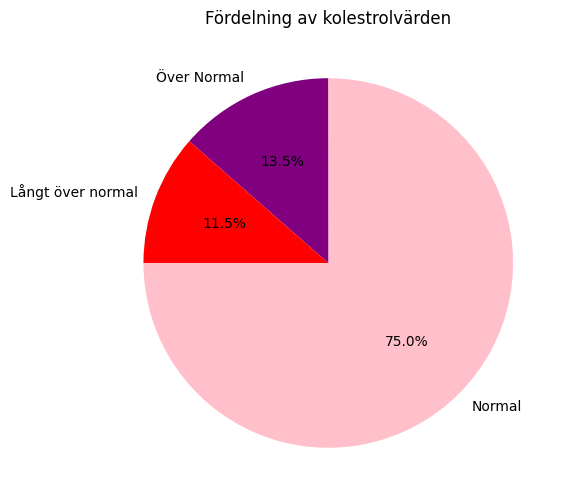

In [5]:
# Räkna antal i varje kategori
cholestrol_counts = df['cholesterol'].value_counts()

# Skapa Pie-chart
plt.figure(figsize=(8, 6))
plt.pie(cholestrol_counts, labels=["Normal", "Över Normal", "Långt över normal"], colors=["pink", "purple", "red"], autopct="%1.1f%%", startangle=180)
plt.title("Fördelning av kolestrolvärden")
plt.show()

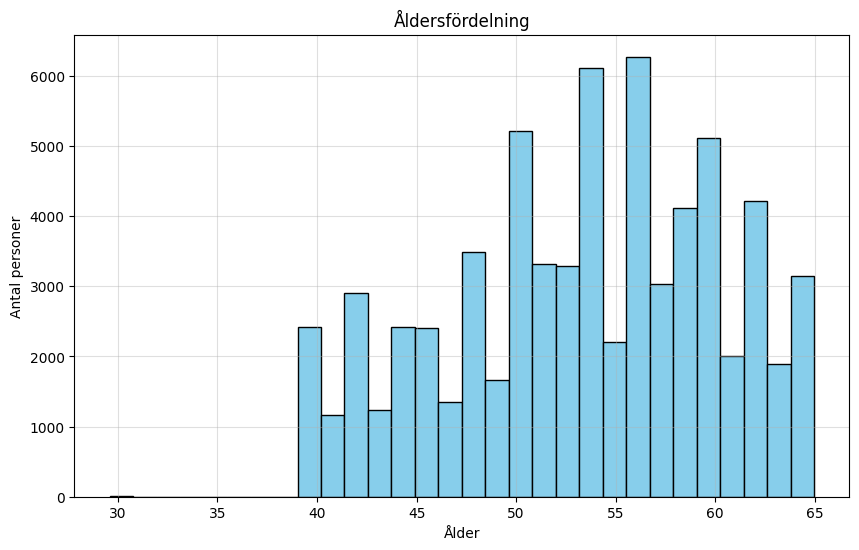

In [6]:
# Skapar ett histogram för att se hur åldersfördelningen ser ut
plt.figure(figsize=(10, 6))
plt.hist(df["age"]/365, bins=30, color="skyblue", edgecolor="black")
plt.title("Åldersfördelning")
plt.xlabel("Ålder")
plt.ylabel("Antal personer")
plt.grid(True, alpha=0.4)
plt.show()

In [7]:
# Beräkna andelen som röker
smokers = df['smoke'].mean() * 100

# Visa resultat
print(f"Andel rökare: {smokers:.2f} %")

Andel rökare: 8.79 %


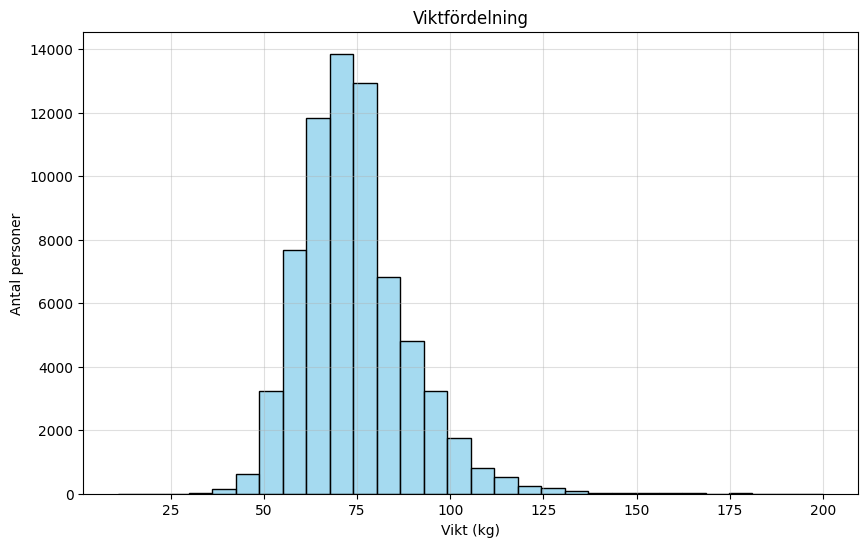

In [8]:
# Skapar ett histogram för att se hur viktfördelningen ser ut
plt.figure(figsize=(10, 6))
sns.histplot(df["weight"], bins=30, color="skyblue", edgecolor="black")
plt.title("Viktfördelning")
plt.xlabel("Vikt (kg)")
plt.ylabel("Antal personer")
plt.grid(True, alpha=0.4)
plt.show()

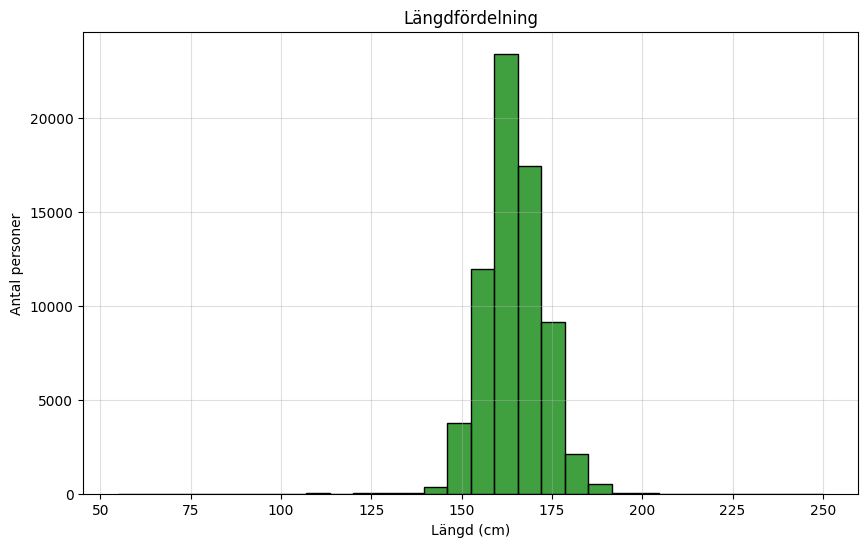

In [9]:
# Skapar ett histogram för att se längdfördelning
plt.figure(figsize=(10, 6))
sns.histplot(df["height"], bins=30, color="green", edgecolor="black")
plt.title("Längdfördelning")
plt.xlabel("Längd (cm)")
plt.ylabel("Antal personer")
plt.grid(True, alpha=0.4)
plt.show()

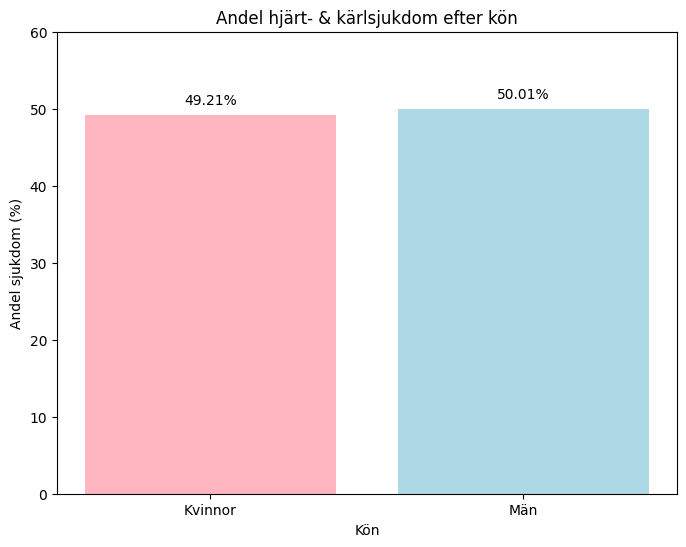

In [10]:
# Beräkna hur stor andel av kvinnor respektive män har hjärt- och kärlsjukdomar

# Gruppera data efter kön och sjukdomsstatus
gender_disease = df.groupby('gender')['cardio'].mean() * 100

# Skapa stapeldiagram
plt.figure(figsize=(8, 6))
bars = plt.bar(['Kvinnor', 'Män'], gender_disease.values, color=['lightpink', 'lightblue'])

# Lägg till procentvärden ovanför varje bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 1, 
             f'{bar.get_height():.2f}%', 
             ha='center', va='bottom')

plt.title('Andel hjärt- & kärlsjukdom efter kön')
plt.xlabel('Kön')
plt.ylabel('Andel sjukdom (%)')
plt.ylim(0, 60)
plt.show()

## Feature engineering BMI
**BMI formel:**
$$
BMI = \frac{weight(kg)}{(height/100)^2(m^2)} = \frac{kg}{m^2}
$$

Där: 
- Vikten är i kilogram (kg)
- Höjden/längden är i centimeter (cm) och divideras med 100 för att konverteras till meter (m)
- Resultatet är i kg/m^2, vilket är den standardiserade enheten för BMI-mätning.

**Ta bort orimliga BMIer och outliers:**

Jag väljer att slänga samples som är utanför 15 och 50 i BMI. Alltså spara dom som är mellan 15-50. Nedan finner jag ett max på outliers upp till ca 300. Dessa max värden är inte rimliga att ha med. Samma med det lägsta värdet på ca 3,5 är inte heller rimlig att ha med.
Varför just mellan 15-50? jag väljera att beräkna med dom som kan ha ett högre BMI pågrund av att det kan vara missvisande för personer som är kroppsbyggare eller elit idrottare. Då vikten kan vara högre än den beräknade längden, som kan ge ett missvisande resultat utifrån formeln.


In [11]:
# Beräkna BMI
df['BMI'] = df['weight'] / (df['height']/100)**2

# Visa statistik för BMI
print("BMI-statistik")
print(df['BMI'].describe())

BMI-statistik
count    68985.000000
mean        27.524761
std          6.081130
min          3.471784
25%         23.875115
50%         26.346494
75%         30.119376
max        298.666667
Name: BMI, dtype: float64


In [12]:
# Filtrera BMI-värden så vi hamnar mellan 15-50
df = df[(df['BMI'] >= 15) & (df['BMI'] <= 50)]

# Skapar en funktion för att kategorisera BMI-värden
def bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight:"
    elif 18.5 <= bmi < 25:
        return "Normal weight:"
    elif 25 <= bmi < 30:
        return "Overweight:"
    elif 30 <= bmi < 35:
        return "Obes class 1:"
    elif 35 <= bmi < 40:
        return "Obes class 2:"
    else:
        return "Obes class 3:"

# Skapa en ny kolumn för kategorisk BMI
df['BMI_category'] = df['BMI'].apply(bmi_category)

# Visa antal i varje kategori
print("Antal i varje BMI-kategori:")
print(df['BMI_category'].value_counts())


Antal i varje BMI-kategori:
BMI_category
Normal weight:    25549
Overweight:       24737
Obes class 1:     11991
Obes class 2:      4241
Obes class 3:      1587
Underweight:        617
Name: count, dtype: int64


## Feature engineering blodtryck

#### Jag använder Blodtryckskategorier enligt Healthline:

| Kategori | Högtryck (Systolisk) | Lågtryck (Diastolisk) |
|----------|----------------------|-----------------------|
| Normalt  | < 120 mmHg          | < 80 mmHg            |
| Över normalt | 120-129 mmHg       | < 80 mmHg            |
| Hypertensivitet stadiet 1 | 130-139 mmHg | 80-89 mmHg |
| Hypertensivitet stadiet 2 | ≥ 140 mmHg    | ≥ 90 mmHg   |
| Hypertensiv kris | ≥ 180 mmHg    | ≥ 120 mmHg  |

#### Blodtryckskategorier:

**Normalt:**
Ett normalt blodtryck är ett systoliskt tryck mindre än 120 millimeter mm Hg och ett diastoliskt tryck mindre än 80 mm Hg. Detta skrivs vanligtvis som 120/80. Blodtrycket är inom det hälsosamma området.

**Över normalt:**
Systoliskt talet är mellan 120 och 129 mm Hg, och diastoliskt talet är mindre än 80 mm Hg. Läkare rekommenderar oftast livsstiländring, det krävs inte medicinsk behandling.

**Hypertensivitet stadiet 1:**
Systoliskt talet är mellan 130 och 139 mm Hg, eller diastoliskt talet är mellan 80 och 89 mm Hg. Blodtrycket är för högt. Det är bekräftad diagnos på högt blodtryck. Läkare rekommenderar livsstiländringar och det kan behövas medicinsk behandling. Blodtrycket bör även övervakas.

**Hypertensivitet stadiet 2:**
Systoliskt talet är 140 mm Hg eller högre, eller diastoliskt talet är 90 mm Hg eller högre. Blodtrycket är allvarligt högt och kan börja orsaka skador på kroppens organ. Aktiv medicinsk behandling krävs för att förhindra allvarliga hälsoproblem samt det behövs nödvändiga livsstilsändringar. Risk finns för hjärtproblem, stroke och njurskador. 

**Hypertensiv kris:**
Systoliskt talet är över 180 mm Hg, eller diastoliskt talet är över 120 mm Hg. Blodtrycket är akut farligt högt och kräver omedelbar medicinsk behandling. Det kan orsaka omedelbar skada på hjärta, hjärna och andra organ. Det kan även orsaka allvarliga komplikationer som: stroke, hjärtattack, njurskador, hjärnskador.

#### **Tar bort orimliga blodtrycks värden och outliers**:
Vi börjar med att vi väljer bort extremt låga och höga värden som kan indikera mätfel på både systoliskt blodtryck (ap_hi) samt diastoliskt blodtryck (ap_low). Detta gör att vi kan bevara alla kliniskt möjliga värden som är inom tabellen ovan och ger då en rimlig marginal för variation. Detta gör att vi kan behålla användbar data för analysen.

In [13]:
# Filtrerar bort orimliga blodtrycksvärden 
# använder gränsen (ap_hi) = 50/250, (ap_lo) = 30/150
df = df[(df['ap_hi'] >= 50) & (df['ap_hi'] <= 250)]
df = df[(df['ap_lo'] >= 30) & (df['ap_lo'] <= 150)]

# Funktion för att kategorisera blodtrycksvärden enligt medicinska riktlinjer
def blood_pressure_category(ap_hi, ap_lo):
    if ap_hi < 120 and ap_lo < 80:
        return "Normal:"
    elif 120 <= ap_hi < 130 and ap_lo < 80:
        return "Elevated:"
    elif 130 <= ap_hi < 140 or 80 <= ap_lo < 90:
        return "Hypertension stage 1:"
    elif ap_hi >= 140 or ap_lo >= 90:
        return "Hypertension stage 2:"
    elif ap_hi >= 180 or ap_lo >= 120:
        return "Hypertension crisis:"
    else:
        return "Data okänd"

# Skapa en ny kolumn för kategorisk blodtryck
df['blood_pressure_category'] = df.apply(lambda x: blood_pressure_category(x['ap_hi'], x['ap_lo']), axis=1)

# Visa antal i varje kategori
print("Antal i varje blodtryckskategori:")
print(df["blood_pressure_category"].value_counts())

Antal i varje blodtryckskategori:
blood_pressure_category
Hypertension stage 1:    39641
Hypertension stage 2:    16222
Normal:                   9530
Elevated:                 3107
Name: count, dtype: int64


## Visualiseringar andel sjukdomar

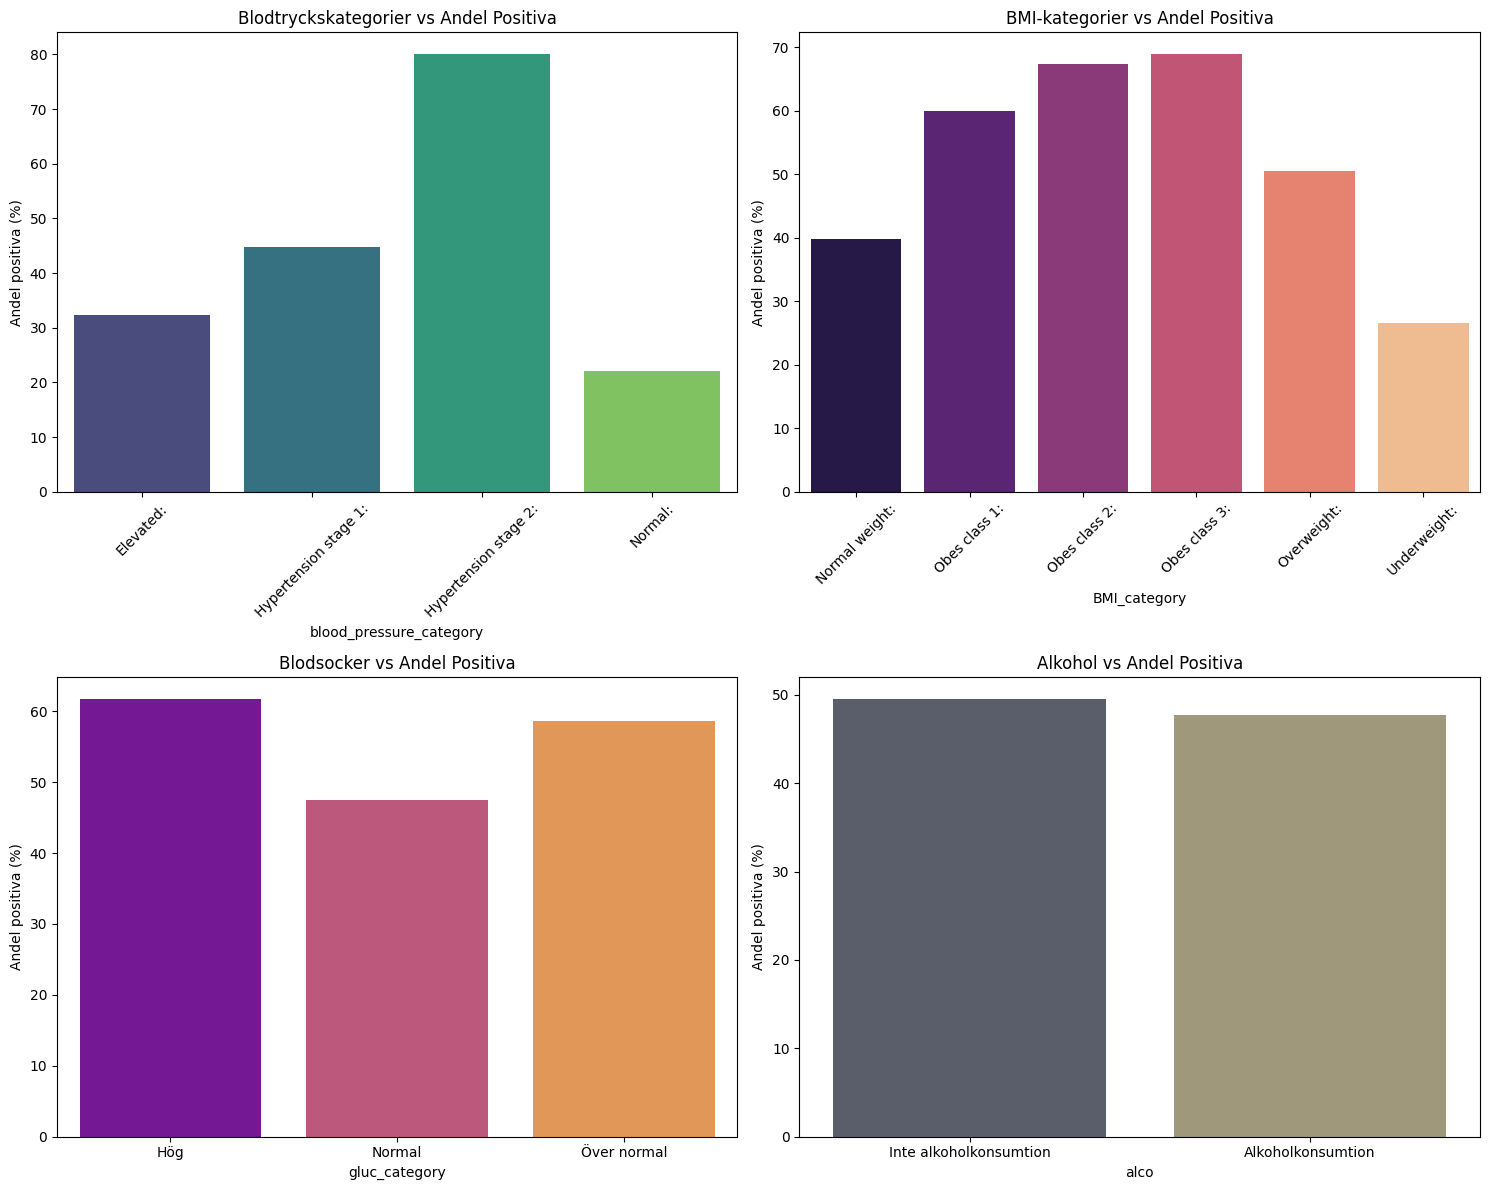

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Skapa en mappning för blodsocker-värden
gluc_mapping = {1: 'Normal', 2: 'Över normal', 3: 'Hög'}

# Skapar en kopia av DataFrame
df_gluc = df.copy()

# Mappa blodsocker-värden till lämpliga etiketter
df_gluc['gluc_category'] = df_gluc['gluc'].map(gluc_mapping)

# Skapa en figur med subplots
plt.figure(figsize=(15, 12))

# Plot 1: Blodtryckskategorier vs andel positiva
plt.subplot(2, 2, 1)
blood_pressure_percent = df.groupby('blood_pressure_category')['cardio'].mean() * 100
sns.barplot(x=blood_pressure_percent.index, y=blood_pressure_percent.values, hue=blood_pressure_percent.index, palette="viridis", legend=False)
plt.title('Blodtryckskategorier vs Andel Positiva')
plt.ylabel('Andel positiva (%)')
plt.xticks(rotation=45)

# Plot 2: BMI-kategorier vs andel positiva
plt.subplot(2, 2, 2)
bmi_percent = df.groupby('BMI_category')['cardio'].mean() * 100
sns.barplot(x=bmi_percent.index, y=bmi_percent.values, hue=bmi_percent.index, palette="magma", legend=False)
plt.title('BMI-kategorier vs Andel Positiva')
plt.ylabel('Andel positiva (%)')
plt.xticks(rotation=45)

# Plot 3: Blodsockernivå vs andel positiva
plt.subplot(2, 2, 3)
gluc_percent = df_gluc.groupby('gluc_category')['cardio'].mean() * 100
sns.barplot(x=gluc_percent.index, y=gluc_percent.values, hue=gluc_percent.index, palette="plasma", legend=False)
plt.title('Blodsocker vs Andel Positiva')
plt.ylabel('Andel positiva (%)')
plt.xticks(rotation=0)  # Roterar etiketter för att de ska stå horisontellt

# Plot 4: Alkohol vs andel positiva
plt.subplot(2, 2, 4)
alcohol_percent = df.groupby('alco')['cardio'].mean() * 100
sns.barplot(x=alcohol_percent.index, y=alcohol_percent.values, hue=alcohol_percent.index, palette="cividis", legend=False)
plt.title('Alkohol vs Andel Positiva')
plt.ylabel('Andel positiva (%)')
plt.xticks(ticks=[0, 1], labels=['Inte alkoholkonsumtion', 'Alkoholkonsumtion'])

#Justera layout för att undvika överlapp
plt.tight_layout()
plt.show()

## Visualiseringar korrelation

Korrelationer sträcker sig från -1.0 till 1.0. 

**Positiv korrelation:**
Två variabler med en korrelation på 1.0, rör sig tillsammans i samma riktning hela tiden och anses vara en perfekt positiv korrelation. Ex. "Du bör träna mer för det hjälper dig att bli fysiskt starkare". Det tyder på en positiv korrelation. Ju mer du tränar dessto mer förväntas du öka i styrka. Rör sig tillsammans i positiv riktning.

**Negativ korrelation:**
Då den ena variablen ökar så minskas den andra variablen. En stark negativ korrelation är -1. Man kan säga att det finns ett orsakssamband, där den ena variablen är orsaken att den andra förändras. Rör sig tillsammans i negativ riktning.

**Noll värde:**
Om värdet är nära noll så är korrelationen mycket svag/obefintlig.

#### **Analys av Korrelationsheatmap:**
Jag väljer att analyser dom värden som sticker ut från heatmapen. Dom värden som är 1.0 är värden som redan beräknas på samma sak. ex. age vs age och rör sig redan i samma positiva riktning.

1. **Längd och Kön:**
 - Korrelation på 0.52, måttligt positiv.
 - Män har generellt högre medellängd än kvinnor. Därmed finns det en viss korrelation mellan kön och längd. 

 2. **Längd och vikt:**
 - Korrelation på 0.32, svag positiv.
 - Längre personer har generellt mer kroppsvolym än kortare människor och väger generellt sätt mer.

 3. **Högt och lågt blodtryck:**
 - Korrelation på 0.70, stark positiv.
 - Det låga blodtrycker och höga blodtrycket påverkas av samma faktorer då mätningarna påverkas av samma fysiologiska processer och riskfaktorer. Högt blodtryck påverkar både systoliskt och diastoliskt tryck.

 4. **Vikt och BMI:**
 - Korrelation på 0.86, Mycket stark positiv. 
 - Direkt matematisk relation då BMI beräknas från vikt och längd.
 - Ju högre vikt man har jämfört med sin längd så leder det till högt BMI. BMI i sig kan dock vara missvisande om du exempelvis är tyngdlyftare eller elitidrottar. Då är det väldigt vanligt att du har ett högt BMI. Dock är det höga BMI resultatet i det fallet oftast ofarligt.

 5. **Kolestrol och Blodsocker:**
 - Korrelation på 0.45, måttligt positiv.
 - Båda påverkas av samma faktorer exempelvis livsstil.
 - Hög kolestrol kan gå i samma riktning med högt blodsocker.

6. **Rökning och Alkohol:**
- Korrelation på 0.34, svag positiv.
- Livstilsvanor. Kan ha en påverkan av sociala faktorer där det förekommer tillsammans.
- Rökning och alkohol kan påverka varandra i kroppen.

7. **Längd och BMI:**
- Korrelation på -0.19, svag negativ.
- Matematisk realation som påverkas av längden. vikt/längd*längd
- Längre personer har lägre BMI på grund av att kroppsvolymen/längden sprider ut vikten. Exempelvis en lång person med samma vikt som en kort person kommer att ha ett lägre BMI.

8. **Cardio och högt blodtryck:**
- Korrelation 0.43, måttligt positiv.
- Högt blodtryck är en välkänd riskfaktor för hjärt- och kärlsjukdomar.
- Påverkar hjärtats arbete och blodkärl. Har ett medicinskt samband och riskfaktor.
- 0.43 av variationen i andelen sjuka personer kan förklaras av blodtryck.


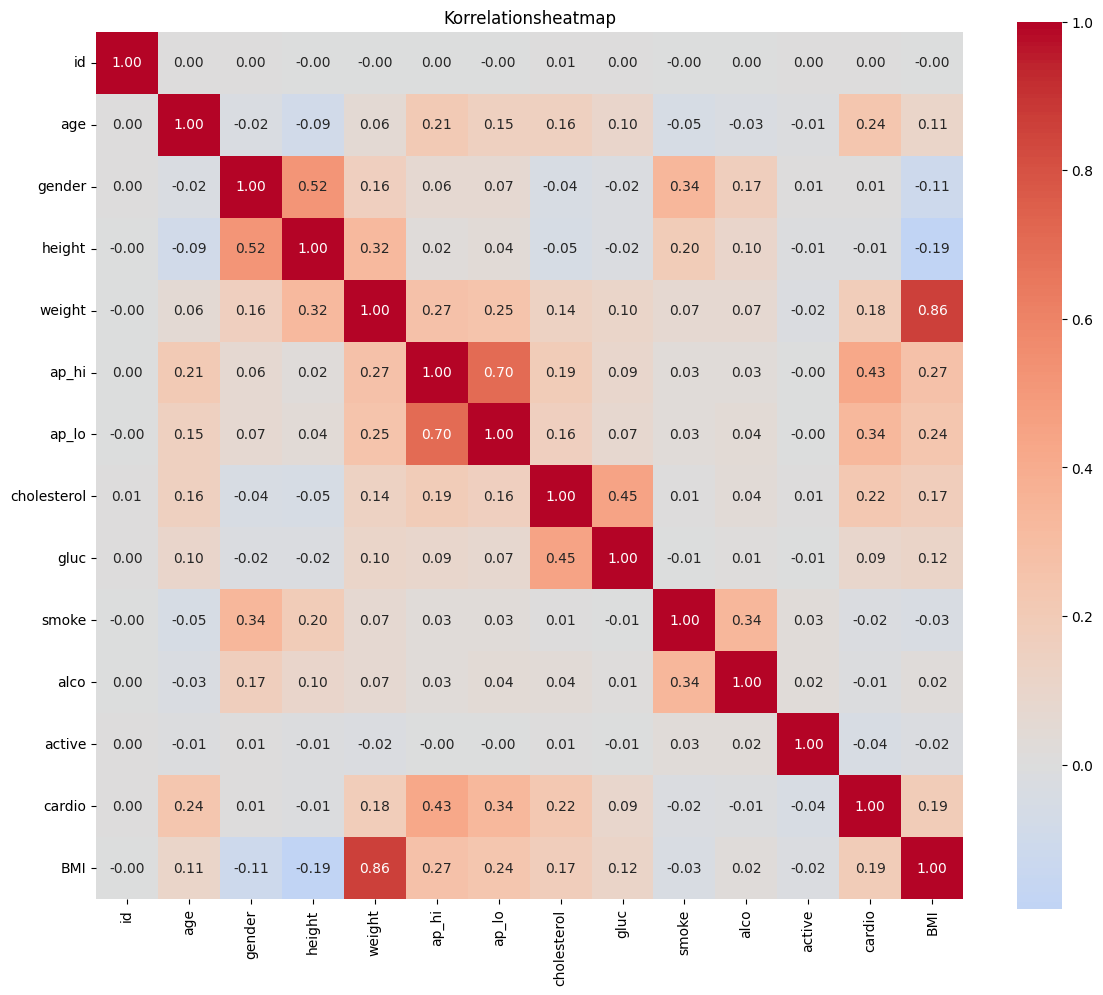

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Skapa en kopia av DataFrame utan kategoriska kolumner
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Beräkna korrelationsmatris
correlation_matrix = df_numeric.corr()

# Skapa en heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True)

# Justera layout
plt.title('Korrelationsheatmap')
plt.tight_layout()

# Visa plot
plt.show()

## Skapa två dataset

In [16]:
# Kopia av DataFrame 
df1 = df.copy()

# Tar bort: aphi, aplo, height, weight, BMI
df1 = df1.drop(["ap_hi", "ap_lo", "height", "weight", "BMI"], axis=1)

# Gör one-hot encoding för BMI-kategori, blodtryckskategori och kön
df1 = pd.get_dummies(df1, columns=['BMI_category', 'blood_pressure_category', 'gender'], drop_first=True, dtype=int)

# Skapa andra dataset
df2 = df.copy()

# Ta bort specificerade features
df2 = df2.drop(['BMI_category', 'blood_pressure_category', 'height', 'weight'], axis=1)

# Gör one-hot encoding för kön
df2 = pd.get_dummies(df2, columns=['gender'], drop_first=True, dtype=int)

# Visa första fem rader av båda dataseten
print("Första dataset:")
print(df1.head())
print("\nAndra dataset:")
print(df2.head())

Första dataset:
   id    age  cholesterol  gluc  smoke  alco  active  cardio  \
0   0  18393            1     1      0     0       1       0   
1   1  20228            3     1      0     0       1       1   
2   2  18857            3     1      0     0       0       1   
3   3  17623            1     1      0     0       1       1   
4   4  17474            1     1      0     0       0       0   

   BMI_category_Obes class 1:  BMI_category_Obes class 2:  \
0                           0                           0   
1                           1                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   BMI_category_Obes class 3:  BMI_category_Overweight:  \
0                           0                         0   
1                           0                         0   
2                           0                         0

## Välj Maskininlärningsmodeller

#### Train-validation-test split

- Träningsdata: Används för att träna modellerna.
- Valideringsdata: Används för att finjustera hyperparametrar och välja den bästa modellen.
- Testdata: Används för att utvärdera modellens prestanda på helt osett data.

In [17]:
from sklearn.model_selection import train_test_split

# Dela upp df1
X1 = df1.drop('cardio', axis=1)  # Features
y1 = df1['cardio']  # Target

# Första delningen: 60% träningsdata, 40% temporär data (validering + test)
X1_train, X1_temp, y1_train, y1_temp = train_test_split(X1, y1, test_size=0.4, random_state=42)

# Andra delningen: 50% validering, 50% test (av de 40%)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_temp, y1_temp, test_size=0.5, random_state=42)

# Dela upp df2
X2 = df2.drop('cardio', axis=1)  # Features
y2 = df2['cardio']  # Target

# Första delningen: 60% träningsdata, 40% temporär data (validering + test)
X2_train, X2_temp, y2_train, y2_temp = train_test_split(X2, y2, test_size=0.4, random_state=42)

# Andra delningen: 50% validering, 50% test (av de 40%)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_temp, y2_temp, test_size=0.5, random_state=42)

print("Storlekar för df1:")
print(f"Träningsdata: {X1_train.shape}, {y1_train.shape}")
print(f"Valideringsdata: {X1_val.shape}, {y1_val.shape}")
print(f"Testdata: {X1_test.shape}, {y1_test.shape}")

print("\nStorlekar för df2:")
print(f"Träningsdata: {X2_train.shape}, {y2_train.shape}")
print(f"Valideringsdata: {X2_val.shape}, {y2_val.shape}")
print(f"Testdata: {X2_test.shape}, {y2_test.shape}")


Storlekar för df1:
Träningsdata: (41100, 16), (41100,)
Valideringsdata: (13700, 16), (13700,)
Testdata: (13700, 16), (13700,)

Storlekar för df2:
Träningsdata: (41100, 11), (41100,)
Valideringsdata: (13700, 11), (13700,)
Testdata: (13700, 11), (13700,)


#### Skala datasetet

Standardization (första omgången). Jag använder StandardScaler för att centrera datan runt medelvärdet och skalar till en standardavvikelse på 1. 
Normalization (andra omgången). Använder jag MinMaxScaler för att skala den redan standardiserade datan till ett intervall mellan [0,1]. 

Både Standardization och Normalization görs på df1 och df2 för tränings-, validerings- och testdata.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Skapa skalare för standardization
standard_scaler = StandardScaler()


# Standardisering, df1
X1_train_standard = standard_scaler.fit_transform(X1_train)
X1_val_standard = standard_scaler.transform(X1_val)
X1_test_standard = standard_scaler.transform(X1_test)

# Standardisering, df2
X2_train_standard = standard_scaler.fit_transform(X2_train)
X2_val_standard = standard_scaler.transform(X2_val)
X2_test_standard = standard_scaler.transform(X2_test)

# Skapa skalare för normalization
minmax_scaler = MinMaxScaler()

# Normalisering, df1
X1_train_minmax = minmax_scaler.fit_transform(X1_train_standard)
X1_val_minmax = minmax_scaler.transform(X1_val_standard)
X1_test_minmax = minmax_scaler.transform(X1_test_standard)

# Normalisering, df2
X2_train_minmax = minmax_scaler.fit_transform(X2_train_standard)
X2_val_minmax = minmax_scaler.transform(X2_val_standard)
X2_test_minmax = minmax_scaler.transform(X2_test_standard)


#### Skapar en funktion för att utföra GridsearchCV

## Hyperperametrar

In [19]:
# Hyperperametrar
# Definiera parametergrid för RandomForest
"""
param_grid_rf = {
    'n_estimators': [10, 20, 30],  # Antal träd i skogen
    'max_depth': [5, 8, 10],  # Maxdjup för varje träd
    'min_samples_split': [10, 15, 20],  # Minsta antal sampel för att dela en nod
    'min_samples_leaf': [2, 3, 4, 5]  # Minsta antal sampel i ett löv
}

# Definiera parametergrid, för LogisticRegression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], #Regulariseringsstyrka
    'penalty': ['l1', 'l2'], # Strafftyp
    'solver': ['saga'] # Optimeringsteknik
}

# Definiera parametergrid för GradienBoostingClassifier
param_grid_gb = {
    'n_estimators': [10, 20, 30], # Antal träd
    'learning_rate': [0.01, 0.1, 1], # Inlärningshastighet
    'max_depth': [3, 5, 10] # Maxdjup för träd
}

# Definiera parametergrid för KneighborsClassifier
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Antal grannar
    'weights': ['uniform', 'distance'],  # Viktning av grannar: 'uniform' eller 'distance'
    'p': [1,2] # Avståndsmått: 1 för Manhattan, 2 för Euklidiskt avstånd
}
"""

"\nparam_grid_rf = {\n    'n_estimators': [10, 20, 30],  # Antal träd i skogen\n    'max_depth': [5, 8, 10],  # Maxdjup för varje träd\n    'min_samples_split': [10, 15, 20],  # Minsta antal sampel för att dela en nod\n    'min_samples_leaf': [2, 3, 4, 5]  # Minsta antal sampel i ett löv\n}\n\n# Definiera parametergrid, för LogisticRegression\nparam_grid_lr = {\n    'C': [0.001, 0.01, 0.1, 1, 10, 100], #Regulariseringsstyrka\n    'penalty': ['l1', 'l2'], # Strafftyp\n    'solver': ['saga'] # Optimeringsteknik\n}\n\n# Definiera parametergrid för GradienBoostingClassifier\nparam_grid_gb = {\n    'n_estimators': [10, 20, 30], # Antal träd\n    'learning_rate': [0.01, 0.1, 1], # Inlärningshastighet\n    'max_depth': [3, 5, 10] # Maxdjup för träd\n}\n\n# Definiera parametergrid för KneighborsClassifier\nparam_grid_knn = {\n    'n_neighbors': [3, 5, 7, 9],  # Antal grannar\n    'weights': ['uniform', 'distance'],  # Viktning av grannar: 'uniform' eller 'distance'\n    'p': [1,2] # Avståndsmå

## Maskininlärnings modeller
- se py fil
- Bästa parametrar: De hyperparametrar som gav bäst resultat vid GridSearchCV.
- Noggrannhet (Accuracy): Andelen korrekta förutsägelser.
- Precision: Andelen korrekta positiva förutsägelser av alla positiva förutsägelser.
- Recall: Andelen korrekta positiva förutsägelser av alla faktiska positiva fall.
- F1-poäng: Ett harmoniskt medelvärde av precision och recall.

In [ ]:
from ml_training_model import train_and_evaluate_models
    
train_and_evaluate_models(X1_train_minmax, X1_val_minmax, X1_test_minmax, X2_train_minmax, X2_val_minmax, X2_test_minmax, y1_train, y1_val, y1_test, y2_train, y2_val, y2_test)
